In [1]:
import pandas as pd

# Load train and test CSV files into DataFrames
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

train_df.sample(10)

,user,item,rating
4144,534,38085,7.0
231570,43078,6895,5.0
209712,38316,112217,9.0
279993,53311,142726,9.0
13332,1032,52061,7.0
78536,10163,174041,9.0
6496,534,40437,10.0
66008,8359,155745,8.0
302006,58170,50514,8.0
291434,55692,16981,6.0


<Axes: title={'center': 'Rating Distribution'}, xlabel='Rating', ylabel='Count'>

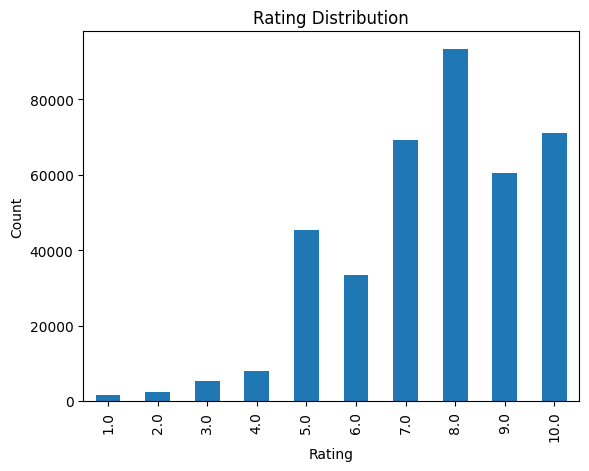

In [2]:
rating_distribution = train_df['rating'].value_counts().sort_index()
rating_distribution.plot(kind='bar', title='Rating Distribution', xlabel='Rating', ylabel='Count')

In [3]:
from surprise import SVDpp, Dataset, Reader
from scipy.sparse import csr_matrix
from surprise.model_selection import train_test_split
from surprise.accuracy import mae

# Convert the train DataFrame to a Surprise dataset
reader = Reader(rating_scale=(train_df['rating'].min(), train_df['rating'].max()))
data = Dataset.load_from_df(train_df[['user', 'item', 'rating']], reader)

# Split the data into train and test sets
trainset, testset = train_test_split(data, test_size=0.2)

# Train the SVD++ algorithm on the trainset
svdpp = SVDpp(reg_all=0.3)
svdpp.fit(trainset)

# Predict ratings for the testset
predictions = svdpp.test(testset)
test_mae = mae(predictions, verbose=False)

# Calculate and print the MAE for trainset (using cross-validation predictions)
train_predictions = [svdpp.predict(uid, iid, r_ui) for (uid, iid, r_ui) in trainset.build_testset()]
train_mae = mae(train_predictions, verbose=False)

# Print the MAE scores
print(f"Train MAE: {train_mae}")
print(f"Test MAE: {test_mae}")

Train MAE: 1.0220557675901503
Test MAE: 1.2764916221907936


In [4]:
from datetime import datetime

testset = [(row['user'], row['item'], 0) for _, row in test_df.iterrows()]
predictions = svdpp.test(testset)

for i, (uid, iid, true_r, est, _) in enumerate(predictions):
    test_df.at[i, 'rating'] = round(est)

# Prepare the output file path with a timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
output_path = f'../out/SVDpp/predicciones_base_{timestamp}.csv'

# Export the result to an Excel file
test_df[['ID', 'rating']].to_csv(output_path, index=False)

print(f"File saved to {output_path}")
test_df.sample(10)

File saved to ../out/SVDpp/predicciones_base_20250329_205239.csv


,ID,user,item,rating
28740,28740,3933,11533,8.0
1838,1838,534,1986,7.0
2832,2832,9422,4700,8.0
27147,27147,10687,15199,8.0
42583,42583,1032,5233,7.0
29795,29795,1032,525,7.0
11709,11709,9950,1937,7.0
32679,32679,2712,9274,9.0
39678,39678,6423,17411,8.0
7033,7033,406,58,8.0


In [5]:
# Center the ratings by subtracting the user mean rating
train_df['user_mean'] = train_df.groupby('user')['rating'].transform('mean')
train_df['rating_centered'] = train_df['rating'] - train_df['user_mean']
train_df.sample(10)

,user,item,rating,user_mean,rating_centered
117792,18677,56259,8.0,7.923077,0.076923
11110,801,26794,8.0,7.000000,1.000000
111788,17524,51292,10.0,7.470472,2.529528
131418,21512,26200,6.0,8.000000,-2.000000
140347,23761,70823,10.0,7.810000,2.190000
226255,42034,64895,10.0,8.125000,1.875000
149742,25636,76625,10.0,9.600000,0.400000
312917,60579,58735,8.0,8.743137,-0.743137
144735,24931,73728,5.0,6.444444,-1.444444
217000,39774,58654,5.0,6.250000,-1.250000


Mean: -7.565481439788591e-18, Std: 1.4102307310578854


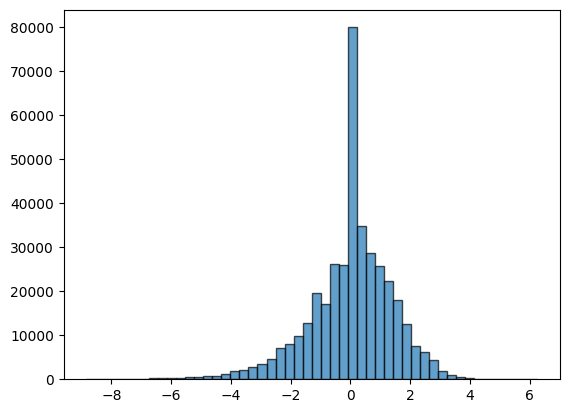

In [6]:
train_df['rating_centered'].hist(bins=50, edgecolor='black', alpha=0.7, grid=False)
mean = train_df['rating_centered'].mean()
std = train_df['rating_centered'].std()
print(f"Mean: {mean}, Std: {std}")

In [7]:
# Convert the train DataFrame with centered ratings to a Surprise dataset
data_centered = Dataset.load_from_df(train_df[['user', 'item', 'rating_centered']], reader)

# Split the data into train and test sets
trainset_centered, testset_centered = train_test_split(data_centered, test_size=0.2)

# Train the SVD++ algorithm on the trainset with centered ratings
svdpp_centered = SVDpp(reg_all=0.3)
svdpp_centered.fit(trainset_centered)

# Predict ratings for the testset
predictions_centered = svdpp_centered.test(testset_centered)
test_mae_centered = mae(predictions_centered, verbose=False)

# Calculate and print the MAE for trainset (using cross-validation predictions)
train_predictions_centered = [svdpp_centered.predict(uid, iid, r_ui) for (uid, iid, r_ui) in trainset_centered.build_testset()]
train_mae_centered = mae(train_predictions_centered, verbose=False)

# Print the MAE scores
print(f"Train MAE (Centered): {train_mae_centered}")
print(f"Test MAE (Centered): {test_mae_centered}")

Train MAE (Centered): 1.3217337241327525
Test MAE (Centered): 1.3239418652586876


In [8]:
# Use the mean rating for each user from the train set
user_mean_map = train_df.set_index('user')['user_mean'].to_dict()
test_df['user_mean'] = test_df['user'].map(user_mean_map)

# Center the ratings by subtracting the user mean rating
test_df['rating_centered'] = test_df['rating'] - test_df['user_mean']

testset = [(row['user'], row['item'], 0) for _, row in test_df.iterrows()]
predictions = svdpp_centered.test(testset)

for i, (uid, iid, true_r, est, _) in enumerate(predictions):
    user_mean = test_df.at[i, 'user_mean'] if not pd.isna(test_df.at[i, 'user_mean']) else 8
    test_df.at[i, 'rating'] = round(est + user_mean)

# Prepare the output file path with a timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
output_path = f'../out/SVDpp/predicciones_SVD_centered_{timestamp}.csv'

# Export the result to an Excel file
test_df[['ID', 'rating']].to_csv(output_path, index=False)

print(f"File saved to {output_path}")
test_df.sample(10)

File saved to ../out/SVDpp/predicciones_SVD_centered_20250329_205526.csv


,ID,user,item,rating,user_mean,rating_centered
2309,2309,6236,17098,7.0,6.122549,0.877451
22801,22801,4536,1104,10.0,9.448276,-0.448276
8571,8571,5404,15822,11.0,9.571429,-0.571429
10917,10917,4201,12313,10.0,8.856320,0.143680
10122,10122,534,3454,8.0,7.289720,0.710280
9943,9943,2904,6340,11.0,9.750000,-0.750000
8895,8895,9851,14751,8.0,7.416667,0.583333
14570,14570,1613,6687,8.0,7.269841,-0.269841
38061,38061,9842,1373,8.0,6.500000,1.500000
27375,27375,5623,16107,9.0,7.542857,0.457143


<Axes: >

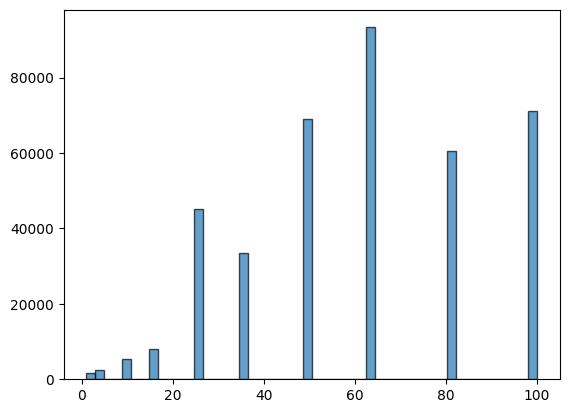

In [9]:
train_df['rating_squared'] = train_df['rating'] ** 2
train_df[['rating', 'rating_squared']].sample(10)
train_df['rating_squared'].hist(bins=50, edgecolor='black', alpha=0.7, grid=False)

In [10]:
# Convert the train DataFrame with rating squared to a Surprise dataset
data_squared = Dataset.load_from_df(train_df[['user', 'item', 'rating_squared']], reader)

# Split the data into train and test sets
trainset_squared, testset_squared = train_test_split(data_squared, test_size=0.2)

# Train the SVD++ algorithm on the trainset with rating squared
svdpp_squared = SVDpp(reg_all=0.3)
svdpp_squared.fit(trainset_squared)

# Predict ratings for the testset
predictions_squared = svdpp_squared.test(testset_squared)
test_mae_squared = mae(predictions_squared, verbose=False)

# Calculate and print the MAE for trainset (using cross-validation predictions)
train_predictions_squared = [svdpp_squared.predict(uid, iid, r_ui) for (uid, iid, r_ui) in trainset_squared.build_testset()]
train_mae_squared = mae(train_predictions_squared, verbose=False)

# Print the MAE scores
print(f"Train MAE (Squared): {train_mae_squared}")
print(f"Test MAE (Squared): {test_mae_squared}")

Train MAE (Squared): 51.32584640184988
Test MAE (Squared): 51.45796534162538


In [11]:
from math import sqrt

testset = [(row['user'], row['item'], 0) for _, row in test_df.iterrows()]
predictions = svdpp_squared.test(testset)

for i, (uid, iid, true_r, est, _) in enumerate(predictions):
    test_df.at[i, 'rating'] = round(sqrt(est))

# Prepare the output file path with a timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
output_path = f'../out/SVDpp/predicciones_SVD_squared_{timestamp}.csv'

# Export the result to an Excel file
test_df[['ID', 'rating']].to_csv(output_path, index=False)

print(f"File saved to {output_path}")
test_df.sample(10)

File saved to ../out/SVDpp/predicciones_SVD_squared_20250329_205818.csv


,ID,user,item,rating,user_mean,rating_centered
28727,28727,4152,10745,3.0,8.300000,-0.300000
17537,17537,8067,2887,3.0,9.000000,-1.000000
39543,39543,1273,5849,3.0,8.534884,-0.534884
40457,40457,9401,824,3.0,6.800000,0.200000
6070,6070,8841,21672,3.0,6.954839,0.045161
37138,37138,2143,7956,3.0,5.591716,0.408284
10628,10628,8535,2667,3.0,8.318182,-0.318182
8686,8686,8434,21119,3.0,5.200000,1.800000
18668,18668,8076,20733,3.0,8.210863,-0.210863
34249,34249,4082,11883,3.0,2.750000,3.250000


In [12]:
from surprise.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'n_factors': [15, 20, 25, 50],
    'lr_all': [0.005, 0.007, 0.01],
    'reg_all': [0.02, 0.1, 0.3]
}

# Perform grid search
grid_search = GridSearchCV(SVDpp, param_grid, measures=['mae'], cv=3, n_jobs=-1)
grid_search.fit(data)

# Get the best parameters and corresponding MAE
best_params = grid_search.best_params['mae']
best_mae = grid_search.best_score['mae']

print(f"Best Parameters: {best_params}")
print(f"Best MAE: {best_mae}")

c:\Users\alexg\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'n_factors': 15, 'lr_all': 0.007, 'reg_all': 0.1}
Best MAE: 1.2751562593967123


In [18]:
reader = Reader(rating_scale=(train_df['rating'].min(), train_df['rating'].max()))
data = Dataset.load_from_df(train_df[['user', 'item', 'rating']], reader)

# Use the best parameters from the grid search to create a new SVD++ instance
best_svdpp = SVDpp(n_factors=best_params['n_factors'], lr_all=best_params['lr_all'], reg_all=best_params['reg_all'])

# Fit the model using the full trainset
best_svdpp.fit(data.build_full_trainset())

train_predictions = [best_svdpp.predict(uid, iid, r_ui) for (uid, iid, r_ui) in data.build_full_trainset().build_testset()]
train_mae = mae(train_predictions, verbose=False)
print(f"Train MAE (Best SVD++): {train_mae}")

# Prepare the testset
testset = [(row['user'], row['item'], 0) for _, row in test_df.iterrows()]
predictions = best_svdpp.test(testset)

for i, (uid, iid, true_r, est, _) in enumerate(predictions):
    test_df.at[i, 'rating'] = round(est)

# Prepare the output file path with parameters and a timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
output_path = f"../out/SVDpp/predicciones_SVD_gridsearch_factors_{best_params['n_factors']}_lr_{best_params['lr_all']}_reg_{best_params['reg_all']}_{timestamp}.csv"

# Export the result to a CSV file
test_df[['ID', 'rating']].to_csv(output_path, index=False)

print(f"File saved to {output_path}")
test_df.sample(10)

Train MAE (Best SVD++): 0.9039085753251793
File saved to ../out/SVDpp/predicciones_SVD_gridsearch_factors_15_lr_0.007_reg_0.1_20250330_000204.csv


,ID,user,item,rating,user_mean,rating_centered
6397,6397,5787,12939,9.0,10.000000,-2.000000
5978,5978,3396,2976,8.0,NaN,NaN
10608,10608,3551,10952,7.0,6.600000,0.400000
5704,5704,8841,21685,5.0,6.954839,0.045161
26077,26077,9306,8395,8.0,7.504202,0.495798
14983,14983,3576,2291,8.0,8.750000,-0.750000
38943,38943,2875,9663,7.0,7.741379,0.258621
14533,14533,2477,8779,8.0,7.795455,0.204545
31472,31472,4201,12979,9.0,8.856320,0.143680
1078,1078,9702,23047,7.0,6.000000,1.000000
